# Ecological Index -  Input dominating index over time
- Calculate historical and future ecological index values from CESM2-LE MARBL NPP, KGP, & FEISTY (demersal only) and penguin population projections (EP and AP).
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- August 2025

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

## How to make ecoindex

- Verify that time (year) and spatial dimensions (lat/lon) are identical for each input
- Only interested in forced change signal, so calculating and using ensemble mean for CESM2 related inputs.
- Penguin projections are median of the future projected populations.
- Calculate ecoindex by summing all inputs. We've weighted each input equally, but could do sums of just some inputs of value (e.g. MARBL only, FEISTY + MARBL, PENGINS only).
- We'll calculate the index for each year 1950-2099, but there are concerns with noise in penguin projections. Thus, we'll also calculate decadal ecoindex values for 1960 - 2090 by averaging 5 years around the decade (e.g. 1980 --> 1978, 1979, 1980, 1981, 1982)
- Only need CCAMLR MPA regions: 1 (Peninsula), 3 (Weddell), 4 (E Weddell), 7 (E. Ant), 8 (Ross), 9 (Bellingshausen and Amundsen)
- Check and test both global and regional scaling **for the EcoIndex only** (not inputs), so each region should have an ecoindex of 1 that shows the maximum *in that region*. We want to see most valuable regions around whole continent and within regions.  This is relevant because management is done regionally by CCAMLR.
- We use maximum value to scale so that the range is 0-1 for Ecoindex. We also tried scaling by median but that didn't really change where was most valuable, just the scaling, so stick with maximum value for ease of communication.

- We need to mask data that is outside the seasonal SIZ. Thus we are implicitly only considering areas that have sea ice, which is critical for ice-obligate species (e.g. krill)
- We will also mask krill and demersal fish using environmental conditions so that we don't consider biomass outside known temperature thresholds for their habitats. Summer SST for krill and annual mean bottom temperature for demersal fish.


## Load Data

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

# load sea ice masks
fin = 'REGION_MASK_gx1v7.nc'
ds_mask = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_mask = ds_mask.isel(time=0)
ds_mask = ds_mask.rename({'lat':'nlat','lon': 'nlon'})
ds_mask['nlat'] = ds_grid.nlat
ds_mask['nlon'] = ds_grid.nlon
ds_mask

<xarray.Dataset>
Dimensions:       (nlon: 320, nlat: 384)
Coordinates:
  * nlon          (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * nlat          (nlat) int64 0 1 2 3 4 5 6 7 ... 377 378 379 380 381 382 383
Data variables: (12/18)
    Lab_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    GIN_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Bar_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ArcOc_mask    (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Sib_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Beau_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...            ...
    Ross_mask     (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Ind_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Pac_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    BAm_mask      (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    nh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    sh_mask       (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)
ds_mask = ds_mask.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [6]:
# keep and convert tarea to km2 from cm2
tarea = ds_grid.TAREA/((100*100)*(1000*1000))

In [7]:
#  make temporary array with only ones for masks
mask_ones = np.ones([len(ds_grid.TLAT.nlat),len(ds_grid.TLAT.nlon)])
mask_ones = xr.DataArray(mask_ones,dims=('nlat','nlon'))
mask_ones['nlat'] = ds_grid.TLAT.nlat
mask_ones['nlon'] = ds_grid.TLAT.nlon

## Load some Environmental data

In [8]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

### Load the CESM2-LE sea ice data
- This is needed to mask the CESM2-LE data so we find maximum **only within the SIZ**
- We want to mask high NPP north of ACC
- Also accounts for ice-obligate species implicitly

In [9]:
# load SIZ
file_in = 'CESM2-LE-SIZ.nc'
ds_siz = xr.open_dataset(path_in+file_in, decode_times=True)

In [10]:
# keep all SIZ data
siz_all = ds_siz.SIZ_SEP

In [11]:
# get ensemble means of SIC for each year to get annual average SIZ
sic_ens_mean = ds_siz.SIC_SEP.mean(dim='member_id')

### Load the CESM2-LE ocean temperature data
- This is needed to mask the CESM2-LE data for habitat suitability so species only exist in known temperature habitat ranges
- Krill only where summer SST <3C
- Demersal Fish only where annual mean bottom temperature are <1C (Toothfish threshold)

In [12]:
# load SST
file_in = 'CESM2-LE-summer-mean-SST.nc'
ds_sst = xr.open_dataset(path_in+file_in, decode_times=True)

In [13]:
ds_sst.time

<xarray.DataArray 'time' (time: 150)>
array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045,
       2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057,
       2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069,
       2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081,
       2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093,
       2094, 2095, 2096, 2097, 2098, 2099])
Coordinates:
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099

In [14]:
# load TBOT
file_in = 'CESM2-LE-annual-mean-TBOT.nc'
ds_tbot = xr.open_dataset(path_in+file_in, decode_times=True)

# cut final year
ds_tbot = ds_tbot.where(ds_tbot.time < 2100, drop=True)

### Load Net Primary Productivity (NPP) data

In [15]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [16]:
# load NPP
file_in = 'CESM2-LE-seasonal-integrals-NPP.nc'
ds_npp = xr.open_dataset(path_in+file_in, decode_times=True)

# use entire growth season
npp = ds_npp.NPP_ONDJFM

In [17]:
# keep only points in the SIZ by year and member
npp_mask = npp.where(siz_all == 1)

In [18]:
# get ensemble mean
npp_mean = npp_mask.mean(dim='member_id')

# replace missing values with 0
npp_mean = npp_mean.fillna(0)

In [19]:
# scale this yearly data by maximum value in whole domain
data = npp_mean
scale_value = data.max(dim=['nlat','nlon'])
npp_scaled = data/scale_value

# mask to omit land points
npp_scaled = npp_scaled.where(ds_grid.REGION_MASK == 1)

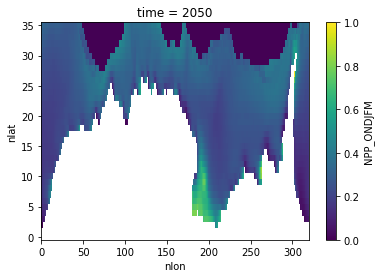

In [20]:
npp_scaled.isel(time=100).plot()

### Load Krill Growth Potential (KGP) data

In [21]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [22]:
# load KGP
file_in = 'CESM2-LE-seasonal-integrals-KGP.nc'
ds_kgp = xr.open_dataset(path_in+file_in, decode_times=True)

# use entire growth season
kgp = ds_kgp.KGP_ONDJFM

# set negative KGP to be zero, then mask land again
kgp = kgp.where(kgp > 0, other=0)
kgp = kgp.where(npp >= 0)

In [23]:
# keep only points in the SIZ by year and member
kgp_mask = kgp.where(siz_all == 1)

In [24]:
# keep only points where summer mean SST is <= 3C by year and member
kgp_mask = kgp_mask.where(ds_sst.SST_ONDJFM <= 3)

In [25]:
# get ensemble mean
kgp_mean = kgp_mask.mean(dim='member_id')

# replace missing values with 0
kgp_mean = kgp_mean.fillna(0)

In [26]:
# scale this yearly data by maximum value in whole domain
data = kgp_mean
scale_value = data.max(dim=['nlat','nlon'])
kgp_scaled = data/scale_value

# mask to omit land points
kgp_scaled = kgp_scaled.where(ds_grid.REGION_MASK == 1)

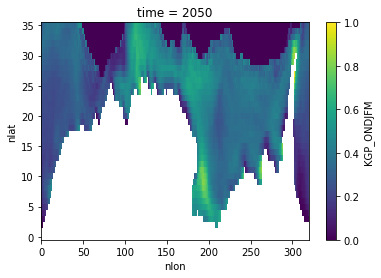

In [27]:
kgp_scaled.isel(time=100).plot()

### Load FEISTY fish data (use demersal fish layer only)

In [28]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/marbl/'

In [29]:
# load FEISTY
file_in = 'CESM2-LE-annual-mean-FEISTY.nc'
ds_feisty = xr.open_dataset(path_in+file_in, decode_times=True)

# use demersal only
demersal = ds_feisty.Demersal

In [30]:
# cut final year
demersal = demersal.where(demersal.time < 2100, drop=True)

In [31]:
# keep only points in the SIZ by year and member
demersal_mask = demersal.where(siz_all == 1)

In [32]:
# keep only points where annual mean TBOT is <= 1C by year and member
demersal_mask = demersal_mask.where(ds_tbot.TEMP_bottom <= 1)

In [33]:
# get ensemble mean
demersal_mean = demersal_mask.mean(dim='member_id')

# replace missing values with 0
demersal_mean = demersal_mean.fillna(0)

In [34]:
# scale this yearly data by maximum value in whole domain
data = demersal_mean
scale_value = data.max(dim=['nlat','nlon'])
demersal_scaled = data/scale_value

# mask to omit land points
demersal_scaled = demersal_scaled.where(ds_grid.REGION_MASK == 1)

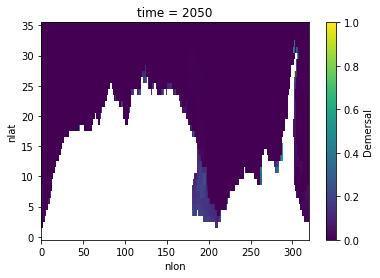

In [35]:
demersal_scaled.isel(time=100).plot()

### Load Emperor Penguin data

In [36]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [37]:
# load Emperor Penguin distances
file_in = 'CESM_grid_Emperor_individual_access_future.nc'
ds_ep = xr.open_dataset(path_in+file_in, decode_times=True)

total_ep = ds_ep.total_penguins

In [38]:
# cut years we don't need
total_ep = total_ep.where(total_ep.time >= 1950, drop=True)
total_ep = total_ep.where(total_ep.time < 2100, drop=True)

In [39]:
# scale this yearly data by maximum value in whole domain
data = total_ep
scale_value = data.max(dim=['nlat','nlon'])
ep_scaled = data/scale_value

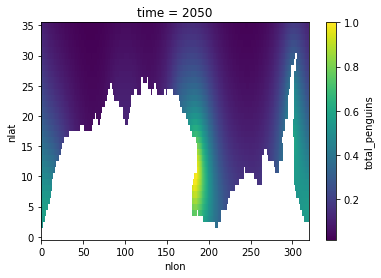

In [40]:
ep_scaled.isel(time=100).plot()

### Load Adelie Penguin data

In [41]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/penguin/'

In [42]:
# load Emperor Penguin distances
file_in = 'CESM_grid_Adelie_individual_access_future.nc'
ds_ap = xr.open_dataset(path_in+file_in, decode_times=True)

total_ap = ds_ap.total_penguins

In [43]:
# cut years we don't need
total_ap = total_ap.where(total_ap.time >= 1950, drop=True)
total_ap = total_ap.where(total_ap.time < 2100, drop=True)

In [44]:
# scale this yearly data by maximum value in whole domain
data = total_ap
scale_value = data.max(dim=['nlat','nlon'])
ap_scaled = data/scale_value

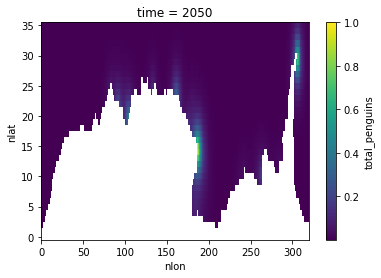

In [45]:
ap_scaled.isel(time=100).plot()

## Make Yearly ecoindex
- Calculate ecoindex by summing all inputs

In [46]:
# sum all inputs
ecoind_raw = npp_scaled + kgp_scaled + demersal_scaled + ep_scaled + ap_scaled

## Calculate fractional contribution of each input

In [47]:
# calculate fractional contribution of each species at each point
npp_frac = 100 * npp_scaled/ecoind_raw
kgp_frac = 100 * kgp_scaled/ecoind_raw
dfp_frac = 100 * demersal_scaled/ecoind_raw
ep_frac = 100 * ep_scaled/ecoind_raw
ap_frac = 100 * ap_scaled/ecoind_raw

In [48]:
# make an array of all the fractional contributions
aev_cont_frac = xr.concat((npp_frac, kgp_frac, dfp_frac, ep_frac, ap_frac),
                          dim='component')

# mask where it's not in the SIZ
aev_cont_frac = aev_cont_frac.where(sic_ens_mean >=0.15)

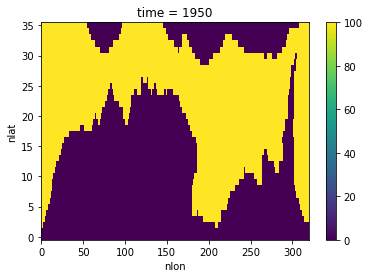

In [49]:
# verify that the fractional contribution sums to 100 at each time
aev_cont_frac.isel(time=0).sum(dim='component').plot()

## Make decadal means
- Calculate decadal index values by averaging 5 years around the decade (e.g. 1980 --> 1978, 1979, 1980, 1981, 1982)
- Also calculate decadal SIZ masks so we can use these for masking

In [50]:
# specify some arrays that will become coordinate arrays
decades = list(range(1960,2100,10))
decade_names = ['1960','1970','1980','1990','2000','2010','2020','2030','2040','2050','2060','2070','2080','2090']

In [51]:
# get dimensions of the grid we need to iterate over
xlen = len(ecoind_raw.nlon)
ylen = len(ecoind_raw.nlat)
dlen = len(decades)
clen = len(aev_cont_frac.component)
print(xlen,ylen,dlen,clen)

320 36 14 5


In [52]:
aev_cont_frac

<xarray.DataArray (component: 5, time: 150, nlat: 36, nlon: 320)>
dask.array<where, shape=(5, 150, 36, 320), dtype=float64, chunksize=(1, 150, 36, 320), chunktype=numpy.ndarray>
Coordinates:
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * time     (time) int64 1950 1951 1952 1953 1954 ... 2095 2096 2097 2098 2099
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -60.25 -60.25 -60.25
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 3.656e+13 3.656e+13
Dimensions without coordinates: component

In [53]:
# Loop through decades

# make numpy array to fill and specify dimensions
array_decadal_regional = np.zeros([dlen,clen,ylen,xlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # subset the hemispheric data for these years only and get mean
    temp = aev_cont_frac.isel(time=aev_cont_frac.time.isin([yy]))
    array_decadal_regional[count,:,:,:] = temp.mean(dim='time')

# convert to xarray
aev_frac_decadal = xr.DataArray(array_decadal_regional,dims=('decades','component','nlat','nlon'))
aev_frac_decadal['decades'] = decades
aev_frac_decadal['nlat'] = ecoind_raw.nlat
aev_frac_decadal['nlon'] = ecoind_raw.nlon

Calculating decadal means for 1960s
Calculating decadal means for 1970s
Calculating decadal means for 1980s
Calculating decadal means for 1990s
Calculating decadal means for 2000s
Calculating decadal means for 2010s
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


## Load polynya data for mask

In [54]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/environment/'

In [55]:
# Read in satellite polynya data
file_in = 'CESM_grid_CESM2-LE_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

In [56]:
# reassign nlat and nlon to be sure we can do calculations
ds_poly['nlat'] = ds_grid.nlat
ds_poly['nlon'] = ds_grid.nlon

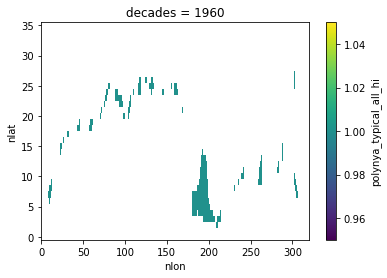

In [57]:
# keep just thickness metric for mask
poly_mask = ds_poly.polynya_typical_all_hi

# modify the mask for later calculations
poly_array = poly_mask.fillna(0)

# test plot
poly_mask.isel(decades=0).plot()

## Load CCAMLR regions for masks

In [58]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [59]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v9_02062025.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

In [60]:
# keep just masks of interest (MPAs, MPA planning areas)
ccamlr_in = ['mpa_plan_1_mod','mpa_plan_3_4','mpa_plan_7_mod','mpa_plan_8','mpa_plan_9',
             'Ross_mpa','Weddell_mpa','Weddell_mpa_2','Ant_Peninsula_mpa','East_Ant_mpa']
ccamlr_masks = ds_ccamlr[ccamlr_in]

In [61]:
# mask of all mpas around whole continent
tmp1 = ccamlr_masks.Ross_mpa.fillna(0)
tmp2 = ccamlr_masks.Weddell_mpa.fillna(0)
tmp3 = ccamlr_masks.Weddell_mpa_2.fillna(0)
tmp4 = ccamlr_masks.Ant_Peninsula_mpa.fillna(0)
tmp5 = ccamlr_masks.East_Ant_mpa.fillna(0)

# add all together
tmp0 = tmp1 + tmp2 + tmp3 + tmp4 + tmp5

# create mask of the mpas
mpa_all = mask_ones.where(tmp0 > 0.0)

In [62]:
# now make xarray with all relevant masks as a new coordinate
ccamlr_all = ['mpa_plan_1_mod','mpa_plan_3_4','mpa_plan_7_mod','mpa_plan_8','mpa_plan_9', 'All_mpa']

ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod,
                          ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9, mpa_all],
                         dim='region')
ccamlr_masks['region'] = ccamlr_all

## Load AEV Binned Data for masks

In [63]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

In [64]:
file_in = 'ecoindex_historical_future_bins.nc'
ds_bin = xr.open_dataset(path_in+file_in, decode_times=True)

In [65]:
# save the bin data
bins_region = ds_bin.aev_bins_region

In [66]:
# combine regional data into a single array for all three bins
data = bins_region

# load the three bins, set missing values to zero
tmp1 = data.isel(bin=0).fillna(0)
tmp2 = data.isel(bin=1).fillna(0)
tmp3 = data.isel(bin=2).fillna(0)

# for each of the three bins, re-label so that bin values are 1, 2, 3 and 0 is "other"
tmp1 = tmp1.where(tmp1 == 0, 3)
tmp2 = tmp2.where(tmp2 == 0, 2)

# add all three together
tmp0 = tmp1 + tmp2 + tmp3

# mask by where we have data or not
tmp0 = tmp0.where(ds_grid.REGION_MASK == 1)

# create mask of the high value points
bins_all = mask_ones.where(tmp0 > 0.0)
#bins_all.plot()

# now make xarray with all relevant masks as a new coordinate
bin_names = ['5pct','10pct','25pct','all']
bin_masks = xr.concat([data.isel(bin=0),data.isel(bin=1),data.isel(bin=2),bins_all], dim = 'bins')
bin_masks['bins'] = bin_names

# assign this info
bin_mask_regions = bin_masks

## Calculate stats for Table 3
- 2 zones: in polynyas, outside polynyas
- 4 bin groups: all bins, bin 1, bin 2, bin 3
- Calculate area weighted average - SUM(TAREA * data)/SUM(TAREA)

## Regions

In [67]:
# set regional data to use
data_calc = aev_frac_decadal
bin_mask = bin_mask_regions

# mask TAREA for each region
tarea_poly = tarea.where((poly_array == 1) & (ccamlr_masks == 1))
tarea_nopoly = tarea.where((poly_array == 0) & (ccamlr_masks == 1))
tarea_bins = tarea.where((bin_mask_regions == 1) & (ccamlr_masks == 1))

## 2000s
- Run everything for 2000s

In [68]:
dec = 2000

### Weddell Sea

In [69]:
# set regional data to use
label = 'Weddell'
reg = 'mpa_plan_3_4'
mpa = 'All_mpa'

In [70]:
# calculate area weighted AVERAGES for 2 zones - in and out polynyas

# IN polynyas
num = tarea_poly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_poly.sel(region=reg,decades=dec)
poly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN polynyas:')
print('NPP')
print(poly_avg.isel(component=0).values)
print('KGP')
print(poly_avg.isel(component=1).values)
print('DFP')
print(poly_avg.isel(component=2).values)
print('EPP')
print(poly_avg.isel(component=3).values)
print('APP')
print(poly_avg.isel(component=4).values)

# OUT polynyas
num = tarea_nopoly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_nopoly.sel(region=reg,decades=dec)
nopoly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution OUT polynyas:')
print('NPP')
print(nopoly_avg.isel(component=0).values)
print('KGP')
print(nopoly_avg.isel(component=1).values)
print('DFP')
print(nopoly_avg.isel(component=2).values)
print('EPP')
print(nopoly_avg.isel(component=3).values)
print('APP')
print(nopoly_avg.isel(component=4).values)

Weddell area weighted average contribution IN polynyas:
NPP
28.452909002784683
KGP
20.09114114614765
DFP
3.0755768883262142
EPP
48.35739061078297
APP
0.022982351958481053
Weddell area weighted average contribution OUT polynyas:
NPP
26.74232516315289
KGP
27.126051495991597
DFP
0.16634231531037075
EPP
43.031384158637266
APP
0.02736148522288617


In [72]:
# calculate average in all bins and print
num = tarea_bins.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_bins.sel(region=reg,decades=dec)
avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN high value bins')
print('order of bins, below')
print(bin_names)
print('NPP')
print(avg.isel(component=0).values)
print('KGP')
print(avg.isel(component=1).values)
print('DFP')
print(avg.isel(component=2).values)
print('EPP')
print(avg.isel(component=3).values)
print('APP')
print(avg.isel(component=4).values)

Weddell area weighted average contribution IN high value bins
order of bins, below
['5pct', '10pct', '25pct', 'all']
NPP
[15.27931878  9.8087496  12.27650239 12.45348905]
KGP
[11.50003378  6.52431195  9.43690529  9.32247095]
DFP
[1.8613202  0.60132664 0.49593422 0.81446209]
EPP
[71.35534676 83.04572699 77.73336991 77.37118156]
APP
[0.00398049 0.01988483 0.05728819 0.03839634]


### East Antarctica

In [73]:
# set regional data to use
label = 'EAntarctica'
reg = 'mpa_plan_7_mod'
mpa = 'All_mpa'

In [74]:
# calculate area weighted AVERAGES for 2 zones - in and out polynyas

# IN polynyas
num = tarea_poly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_poly.sel(region=reg,decades=dec)
poly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN polynyas:')
print('NPP')
print(poly_avg.isel(component=0).values)
print('KGP')
print(poly_avg.isel(component=1).values)
print('DFP')
print(poly_avg.isel(component=2).values)
print('EPP')
print(poly_avg.isel(component=3).values)
print('APP')
print(poly_avg.isel(component=4).values)

# OUT polynyas
num = tarea_nopoly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_nopoly.sel(region=reg,decades=dec)
nopoly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution OUT polynyas:')
print('NPP')
print(nopoly_avg.isel(component=0).values)
print('KGP')
print(nopoly_avg.isel(component=1).values)
print('DFP')
print(nopoly_avg.isel(component=2).values)
print('EPP')
print(nopoly_avg.isel(component=3).values)
print('APP')
print(nopoly_avg.isel(component=4).values)

EAntarctica area weighted average contribution IN polynyas:
NPP
33.73923973591966
KGP
28.7594982304801
DFP
6.241760956400758
EPP
23.402437769401153
APP
7.857063307798323
EAntarctica area weighted average contribution OUT polynyas:
NPP
28.24218918197014
KGP
31.70298675525669
DFP
0.340010585342975
EPP
16.697008998767696
APP
1.666449604376877


In [75]:
# calculate average in all bins and print
num = tarea_bins.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_bins.sel(region=reg,decades=dec)
avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN high value bins')
print('order of bins, below')
print(bin_names)
print('NPP')
print(avg.isel(component=0).values)
print('KGP')
print(avg.isel(component=1).values)
print('DFP')
print(avg.isel(component=2).values)
print('EPP')
print(avg.isel(component=3).values)
print('APP')
print(avg.isel(component=4).values)

EAntarctica area weighted average contribution IN high value bins
order of bins, below
['5pct', '10pct', '25pct', 'all']
NPP
[31.53794899 34.13425585 33.30114807 33.11859996]
KGP
[34.40782002 37.03094496 45.54099529 41.48589838]
DFP
[5.34568459 0.58210942 0.72723479 1.63475766]
EPP
[22.89935486 24.31134971 18.41479964 20.56855364]
APP
[5.80919154 3.94134005 2.01582221 3.19219036]


### Ross Sea

In [76]:
# set regional data to use
label = 'Ross'
reg = 'mpa_plan_8'
mpa = 'All_mpa'

In [77]:
# calculate area weighted AVERAGES for 2 zones - in and out polynyas

# IN polynyas
num = tarea_poly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_poly.sel(region=reg,decades=dec)
poly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN polynyas:')
print('NPP')
print(poly_avg.isel(component=0).values)
print('KGP')
print(poly_avg.isel(component=1).values)
print('DFP')
print(poly_avg.isel(component=2).values)
print('EPP')
print(poly_avg.isel(component=3).values)
print('APP')
print(poly_avg.isel(component=4).values)

# OUT polynyas
num = tarea_nopoly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_nopoly.sel(region=reg,decades=dec)
nopoly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution OUT polynyas:')
print('NPP')
print(nopoly_avg.isel(component=0).values)
print('KGP')
print(nopoly_avg.isel(component=1).values)
print('DFP')
print(nopoly_avg.isel(component=2).values)
print('EPP')
print(nopoly_avg.isel(component=3).values)
print('APP')
print(nopoly_avg.isel(component=4).values)

Ross area weighted average contribution IN polynyas:
NPP
30.578413997346345
KGP
27.869388451185767
DFP
8.069156496144968
EPP
31.21577575604919
APP
2.2672652992737374
Ross area weighted average contribution OUT polynyas:
NPP
22.18871867129036
KGP
26.24614205120748
DFP
0.4452012016225276
EPP
26.07503392869064
APP
1.2347886469837488


In [78]:
# calculate average in all bins and print
num = tarea_bins.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_bins.sel(region=reg,decades=dec)
avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN high value bins')
print('order of bins, below')
print(bin_names)
print('NPP')
print(avg.isel(component=0).values)
print('KGP')
print(avg.isel(component=1).values)
print('DFP')
print(avg.isel(component=2).values)
print('EPP')
print(avg.isel(component=3).values)
print('APP')
print(avg.isel(component=4).values)

Ross area weighted average contribution IN high value bins
order of bins, below
['5pct', '10pct', '25pct', 'all']
NPP
[28.24929909 27.30005513 25.05317307 26.0803131 ]
KGP
[26.78621483 25.61984732 28.19259863 27.43256469]
DFP
[8.8145886  7.25522464 3.86261099 5.43679209]
EPP
[32.80764158 34.94108068 37.41083755 36.08053453]
APP
[3.3422559  4.88379224 5.48077977 4.96979559]


### Amundsen Sea

In [79]:
# set regional data to use
label = 'Amundsen'
reg = 'mpa_plan_9'
mpa = 'All_mpa'

In [80]:
# calculate area weighted AVERAGES for 2 zones - in and out polynyas

# IN polynyas
num = tarea_poly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_poly.sel(region=reg,decades=dec)
poly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN polynyas:')
print('NPP')
print(poly_avg.isel(component=0).values)
print('KGP')
print(poly_avg.isel(component=1).values)
print('DFP')
print(poly_avg.isel(component=2).values)
print('EPP')
print(poly_avg.isel(component=3).values)
print('APP')
print(poly_avg.isel(component=4).values)

# OUT polynyas
num = tarea_nopoly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_nopoly.sel(region=reg,decades=dec)
nopoly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution OUT polynyas:')
print('NPP')
print(nopoly_avg.isel(component=0).values)
print('KGP')
print(nopoly_avg.isel(component=1).values)
print('DFP')
print(nopoly_avg.isel(component=2).values)
print('EPP')
print(nopoly_avg.isel(component=3).values)
print('APP')
print(nopoly_avg.isel(component=4).values)

Amundsen area weighted average contribution IN polynyas:
NPP
39.83819192272464
KGP
35.88644289774033
DFP
6.684173049944726
EPP
15.052803711801786
APP
2.538388417788508
Amundsen area weighted average contribution OUT polynyas:
NPP
26.864918329639615
KGP
29.55976780222471
DFP
0.11024270210286194
EPP
15.755179396248172
APP
0.2794781227855535


In [81]:
# calculate average in all bins and print
num = tarea_bins.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_bins.sel(region=reg,decades=dec)
avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN high value bins')
print('order of bins, below')
print(bin_names)
print('NPP')
print(avg.isel(component=0).values)
print('KGP')
print(avg.isel(component=1).values)
print('DFP')
print(avg.isel(component=2).values)
print('EPP')
print(avg.isel(component=3).values)
print('APP')
print(avg.isel(component=4).values)

Amundsen area weighted average contribution IN high value bins
order of bins, below
['5pct', '10pct', '25pct', 'all']
NPP
[38.32473722 39.35979409 40.22534529 39.85088457]
KGP
[37.68406536 39.84363185 42.99196876 41.84548727]
DFP
[3.09960617 0.12711855 0.11976057 0.52092723]
EPP
[19.18302503 20.49770291 16.47174867 17.39043507]
APP
[1.70856622 0.1717526  0.19117671 0.39226586]


### Antarctic Peninsula

In [82]:
# set regional data to use
label = 'AntPeninsula'
reg = 'mpa_plan_1_mod'
mpa = 'All_mpa'

In [83]:
# calculate area weighted AVERAGES for 2 zones - in and out polynyas

# IN polynyas
num = tarea_poly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_poly.sel(region=reg,decades=dec)
poly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN polynyas:')
print('NPP')
print(poly_avg.isel(component=0).values)
print('KGP')
print(poly_avg.isel(component=1).values)
print('DFP')
print(poly_avg.isel(component=2).values)
print('EPP')
print(poly_avg.isel(component=3).values)
print('APP')
print(poly_avg.isel(component=4).values)

# OUT polynyas
num = tarea_nopoly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_nopoly.sel(region=reg,decades=dec)
nopoly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution OUT polynyas:')
print('NPP')
print(nopoly_avg.isel(component=0).values)
print('KGP')
print(nopoly_avg.isel(component=1).values)
print('DFP')
print(nopoly_avg.isel(component=2).values)
print('EPP')
print(nopoly_avg.isel(component=3).values)
print('APP')
print(nopoly_avg.isel(component=4).values)

AntPeninsula area weighted average contribution IN polynyas:
NPP
25.804985049732146
KGP
22.168341303838556
DFP
23.27968634973929
EPP
25.38687431814964
APP
3.3601129785403727
AntPeninsula area weighted average contribution OUT polynyas:
NPP
22.375014327113234
KGP
24.136790173369583
DFP
0.5613459616750489
EPP
31.48510703222982
APP
3.3230638926259566


In [84]:
# calculate average in all bins and print
num = tarea_bins.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_bins.sel(region=reg,decades=dec)
avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN high value bins')
print('order of bins, below')
print(bin_names)
print('NPP')
print(avg.isel(component=0).values)
print('KGP')
print(avg.isel(component=1).values)
print('DFP')
print(avg.isel(component=2).values)
print('EPP')
print(avg.isel(component=3).values)
print('APP')
print(avg.isel(component=4).values)

AntPeninsula area weighted average contribution IN high value bins
order of bins, below
['5pct', '10pct', '25pct', 'all']
NPP
[22.89250822 24.68823517 28.91697776 26.72254855]
KGP
[29.88584816 31.57050847 32.65946953 31.83154084]
DFP
[8.13933952 2.64361832 0.92509354 2.84177167]
EPP
[18.42245564 25.04375044 29.88646122 26.39178966]
APP
[20.65984846 16.05388759  7.61199796 12.21234928]


## 2090s
- Run everything for 2090s

In [85]:
dec = 2090

### Weddell Sea

In [86]:
# set regional data to use
label = 'Weddell'
reg = 'mpa_plan_3_4'
mpa = 'All_mpa'

In [87]:
# calculate area weighted AVERAGES for 2 zones - in and out polynyas

# IN polynyas
num = tarea_poly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_poly.sel(region=reg,decades=dec)
poly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN polynyas:')
print('NPP')
print(poly_avg.isel(component=0).values)
print('KGP')
print(poly_avg.isel(component=1).values)
print('DFP')
print(poly_avg.isel(component=2).values)
print('EPP')
print(poly_avg.isel(component=3).values)
print('APP')
print(poly_avg.isel(component=4).values)

# OUT polynyas
num = tarea_nopoly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_nopoly.sel(region=reg,decades=dec)
nopoly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution OUT polynyas:')
print('NPP')
print(nopoly_avg.isel(component=0).values)
print('KGP')
print(nopoly_avg.isel(component=1).values)
print('DFP')
print(nopoly_avg.isel(component=2).values)
print('EPP')
print(nopoly_avg.isel(component=3).values)
print('APP')
print(nopoly_avg.isel(component=4).values)

Weddell area weighted average contribution IN polynyas:
NPP
36.78306323783264
KGP
37.248150273780496
DFP
0.0
EPP
25.941708373357788
APP
0.02707811502907701
Weddell area weighted average contribution OUT polynyas:
NPP
22.822916254591988
KGP
24.240694771346273
DFP
0.11572778305071305
EPP
9.10410391544422
APP
0.009739172404492947


In [88]:
# calculate average in all bins and print
num = tarea_bins.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_bins.sel(region=reg,decades=dec)
avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN high value bins')
print('order of bins, below')
print(bin_names)
print('NPP')
print(avg.isel(component=0).values)
print('KGP')
print(avg.isel(component=1).values)
print('DFP')
print(avg.isel(component=2).values)
print('EPP')
print(avg.isel(component=3).values)
print('APP')
print(avg.isel(component=4).values)

Weddell area weighted average contribution IN high value bins
order of bins, below
['5pct', '10pct', '25pct', 'all']
NPP
[31.06313382 30.52874082 35.95894773 34.02954338]
KGP
[32.94251254 35.31554651 47.06429001 42.2640993 ]
DFP
[2.49074714 0.51072438 0.01996436 0.55396594]
EPP
[33.37758529 33.56818809 16.93721142 23.10275091]
APP
[0.1260212  0.07680019 0.01958648 0.04964046]


### East Antarctica

In [89]:
# set regional data to use
label = 'EAntarctica'
reg = 'mpa_plan_7_mod'
mpa = 'All_mpa'

In [90]:
# calculate area weighted AVERAGES for 2 zones - in and out polynyas

# IN polynyas
num = tarea_poly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_poly.sel(region=reg,decades=dec)
poly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN polynyas:')
print('NPP')
print(poly_avg.isel(component=0).values)
print('KGP')
print(poly_avg.isel(component=1).values)
print('DFP')
print(poly_avg.isel(component=2).values)
print('EPP')
print(poly_avg.isel(component=3).values)
print('APP')
print(poly_avg.isel(component=4).values)

# OUT polynyas
num = tarea_nopoly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_nopoly.sel(region=reg,decades=dec)
nopoly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution OUT polynyas:')
print('NPP')
print(nopoly_avg.isel(component=0).values)
print('KGP')
print(nopoly_avg.isel(component=1).values)
print('DFP')
print(nopoly_avg.isel(component=2).values)
print('EPP')
print(nopoly_avg.isel(component=3).values)
print('APP')
print(nopoly_avg.isel(component=4).values)

EAntarctica area weighted average contribution IN polynyas:
NPP
35.97473605295604
KGP
48.05851648647495
DFP
5.055849581524802
EPP
3.320709111802133
APP
7.590188767242056
EAntarctica area weighted average contribution OUT polynyas:
NPP
23.636173819024528
KGP
23.56917738441466
DFP
0.1918661223243927
EPP
2.13514861787549
APP
1.4383709187350362


In [91]:
# calculate average in all bins and print
num = tarea_bins.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_bins.sel(region=reg,decades=dec)
avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN high value bins')
print('order of bins, below')
print(bin_names)
print('NPP')
print(avg.isel(component=0).values)
print('KGP')
print(avg.isel(component=1).values)
print('DFP')
print(avg.isel(component=2).values)
print('EPP')
print(avg.isel(component=3).values)
print('APP')
print(avg.isel(component=4).values)

EAntarctica area weighted average contribution IN high value bins
order of bins, below
['5pct', '10pct', '25pct', 'all']
NPP
[32.67494605 29.50992541 34.60228494 33.15781612]
KGP
[49.4117602  52.10287623 58.46387044 55.46818614]
DFP
[7.58115661 2.78432735 1.07981676 2.61331231]
EPP
[4.53044875 9.50724347 3.34494168 4.88728965]
APP
[5.8016884  6.09562754 2.50908618 3.87339578]


### Ross Sea

In [92]:
# set regional data to use
label = 'Ross'
reg = 'mpa_plan_8'
mpa = 'All_mpa'

In [93]:
# calculate area weighted AVERAGES for 2 zones - in and out polynyas

# IN polynyas
num = tarea_poly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_poly.sel(region=reg,decades=dec)
poly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN polynyas:')
print('NPP')
print(poly_avg.isel(component=0).values)
print('KGP')
print(poly_avg.isel(component=1).values)
print('DFP')
print(poly_avg.isel(component=2).values)
print('EPP')
print(poly_avg.isel(component=3).values)
print('APP')
print(poly_avg.isel(component=4).values)

# OUT polynyas
num = tarea_nopoly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_nopoly.sel(region=reg,decades=dec)
nopoly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution OUT polynyas:')
print('NPP')
print(nopoly_avg.isel(component=0).values)
print('KGP')
print(nopoly_avg.isel(component=1).values)
print('DFP')
print(nopoly_avg.isel(component=2).values)
print('EPP')
print(nopoly_avg.isel(component=3).values)
print('APP')
print(nopoly_avg.isel(component=4).values)

Ross area weighted average contribution IN polynyas:
NPP
30.147585123695194
KGP
27.58906778030851
DFP
8.319818054492234
EPP
30.886774105184482
APP
3.056754936319581
Ross area weighted average contribution OUT polynyas:
NPP
16.808264973525684
KGP
30.634358319081194
DFP
0.3758863810293408
EPP
16.43229669825232
APP
1.7980287501832928


In [94]:
# calculate average in all bins and print
num = tarea_bins.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_bins.sel(region=reg,decades=dec)
avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN high value bins')
print('order of bins, below')
print(bin_names)
print('NPP')
print(avg.isel(component=0).values)
print('KGP')
print(avg.isel(component=1).values)
print('DFP')
print(avg.isel(component=2).values)
print('EPP')
print(avg.isel(component=3).values)
print('APP')
print(avg.isel(component=4).values)

Ross area weighted average contribution IN high value bins
order of bins, below
['5pct', '10pct', '25pct', 'all']
NPP
[21.54083147 26.13218387 23.54598552 23.61417145]
KGP
[27.94604224 24.23572189 32.72612371 30.11078704]
DFP
[7.21916544 6.71159703 3.71880158 5.02276683]
EPP
[31.58829328 35.75476731 31.85204225 32.53627016]
APP
[11.70566756  7.16572989  8.15704693  8.71600452]


### Amundsen Sea

In [95]:
# set regional data to use
label = 'Amundsen'
reg = 'mpa_plan_9'
mpa = 'All_mpa'

In [96]:
# calculate area weighted AVERAGES for 2 zones - in and out polynyas

# IN polynyas
num = tarea_poly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_poly.sel(region=reg,decades=dec)
poly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN polynyas:')
print('NPP')
print(poly_avg.isel(component=0).values)
print('KGP')
print(poly_avg.isel(component=1).values)
print('DFP')
print(poly_avg.isel(component=2).values)
print('EPP')
print(poly_avg.isel(component=3).values)
print('APP')
print(poly_avg.isel(component=4).values)

# OUT polynyas
num = tarea_nopoly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_nopoly.sel(region=reg,decades=dec)
nopoly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution OUT polynyas:')
print('NPP')
print(nopoly_avg.isel(component=0).values)
print('KGP')
print(nopoly_avg.isel(component=1).values)
print('DFP')
print(nopoly_avg.isel(component=2).values)
print('EPP')
print(nopoly_avg.isel(component=3).values)
print('APP')
print(nopoly_avg.isel(component=4).values)

Amundsen area weighted average contribution IN polynyas:
NPP
37.25747553425314
KGP
49.100230751775214
DFP
0.0
EPP
7.454957752856657
APP
6.187335961115
Amundsen area weighted average contribution OUT polynyas:
NPP
15.555045060390663
KGP
21.252868389768054
DFP
0.07062740635912526
EPP
4.493944197527103
APP
0.5512989486046915


In [97]:
# calculate average in all bins and print
num = tarea_bins.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_bins.sel(region=reg,decades=dec)
avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN high value bins')
print('order of bins, below')
print(bin_names)
print('NPP')
print(avg.isel(component=0).values)
print('KGP')
print(avg.isel(component=1).values)
print('DFP')
print(avg.isel(component=2).values)
print('EPP')
print(avg.isel(component=3).values)
print('APP')
print(avg.isel(component=4).values)

Amundsen area weighted average contribution IN high value bins
order of bins, below
['5pct', '10pct', '25pct', 'all']
NPP
[35.23287443 32.81971358 35.74511162 34.9452664 ]
KGP
[49.85402644 50.95077751 49.59264426 49.96915095]
DFP
[0.74501254 0.03402211 0.28355237 0.3261988 ]
EPP
[ 7.54762664 13.91834843 12.87256616 11.94958345]
APP
[6.62045995 2.27713837 1.50612559 2.8098004 ]


### Antarctic Peninsula

In [98]:
# set regional data to use
label = 'AntPeninsula'
reg = 'mpa_plan_1_mod'
mpa = 'All_mpa'

In [99]:
# calculate area weighted AVERAGES for 2 zones - in and out polynyas

# IN polynyas
num = tarea_poly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_poly.sel(region=reg,decades=dec)
poly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN polynyas:')
print('NPP')
print(poly_avg.isel(component=0).values)
print('KGP')
print(poly_avg.isel(component=1).values)
print('DFP')
print(poly_avg.isel(component=2).values)
print('EPP')
print(poly_avg.isel(component=3).values)
print('APP')
print(poly_avg.isel(component=4).values)

# OUT polynyas
num = tarea_nopoly.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_nopoly.sel(region=reg,decades=dec)
nopoly_avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution OUT polynyas:')
print('NPP')
print(nopoly_avg.isel(component=0).values)
print('KGP')
print(nopoly_avg.isel(component=1).values)
print('DFP')
print(nopoly_avg.isel(component=2).values)
print('EPP')
print(nopoly_avg.isel(component=3).values)
print('APP')
print(nopoly_avg.isel(component=4).values)

AntPeninsula area weighted average contribution IN polynyas:
NPP
33.37244253274832
KGP
30.228927848563558
DFP
23.25112133521053
EPP
10.77302580045565
APP
2.3744824830219327
AntPeninsula area weighted average contribution OUT polynyas:
NPP
19.654915413320193
KGP
19.67400630270805
DFP
0.40404022533164735
EPP
10.97774187142517
APP
1.085221398476197


In [100]:
# calculate average in all bins and print
num = tarea_bins.sel(region=reg,decades=dec)*aev_frac_decadal.sel(decades=dec)
denom = tarea_bins.sel(region=reg,decades=dec)
avg = num.sum(dim=["nlat", "nlon"])/denom.sum(dim=["nlat", "nlon"])

# print values
print(label + ' area weighted average contribution IN high value bins')
print('order of bins, below')
print(bin_names)
print('NPP')
print(avg.isel(component=0).values)
print('KGP')
print(avg.isel(component=1).values)
print('DFP')
print(avg.isel(component=2).values)
print('EPP')
print(avg.isel(component=3).values)
print('APP')
print(avg.isel(component=4).values)

AntPeninsula area weighted average contribution IN high value bins
order of bins, below
['5pct', '10pct', '25pct', 'all']
NPP
[33.33936647 34.81021372 35.84674385 35.21123546]
KGP
[33.25830398 37.91531239 30.34744185 32.11538094]
DFP
[15.45027542  3.35745117  0.55523326  3.78737733]
EPP
[14.15369557 19.30024375 28.89981216 24.59522967]
APP
[3.79835855 4.61677897 4.35076888 4.2907766 ]


NameError: name 'circle' is not defined

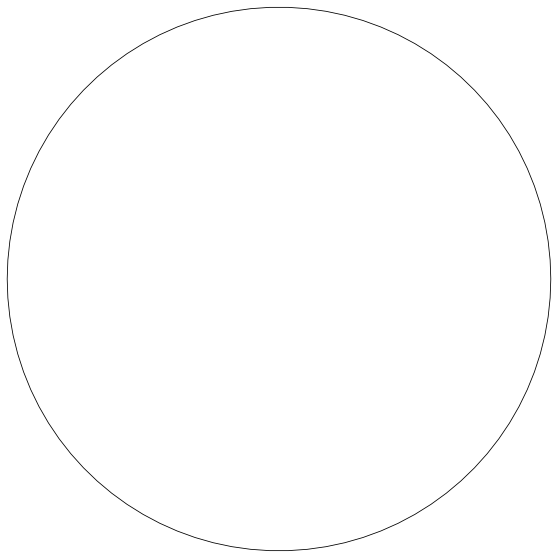

In [101]:
# Plot - 2000s
dec = 2000

# create figure
fig = plt.figure(figsize=(10,10))
fout = 'Figure_5_input_fractions_'+str(dec)

# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Dominant Species Info
lon, lat, field = utils.adjust_pop_grid(lons,lats,species.sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_species,                      
                     vmax=4, vmin=0,
                     transform=ccrs.PlateCarree())

tk = np.arange(0.4, 4, 0.8)
cbar = ax.figure.colorbar(this,ticks=tk, orientation='horizontal',extend='neither',fraction=0.05,pad=0.05,shrink=0.8,)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel(r'Largest Input to AEV Index',fontsize='xx-large')
cbar.ax.set_xticklabels(['NPP','KGP','DFP','EPP','APP'], fontsize='xx-large')

### Overlay dots where values are < 10% different from next nearest contribution 
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct_10.sel(decades=dec))
this1 = ax.scatter(lon, lat,
                   field,
                   color='darkgrey', marker='.', linewidths=1,
                   transform=ccrs.PlateCarree())

### Overlay valuable areas - too noisy, remove
#lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_high.fillna(0))
#this2=ax.contour(lon,lat,field,
#                 colors='grey',linestyles='solid',linewidths=3,
#                 levels=levels_in_ctr,
#                 transform=ccrs.PlateCarree()) 

### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
fig.suptitle('a) 2000s',fontsize=20, x=0.25, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [ ]:
# Plot - 2090s
dec = 2090

# create figure
fig = plt.figure(figsize=(10,10))
fout = 'Figure_5_input_fractions_'+str(dec)

# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Dominant Species Info
lon, lat, field = utils.adjust_pop_grid(lons,lats,species.sel(decades=dec))
this=ax.pcolormesh(lon,lat,
                     field,
                     cmap=cmap_species,                      
                     vmax=4, vmin=0,
                     transform=ccrs.PlateCarree())

tk = np.arange(0.4, 4, 0.8)
cbar = ax.figure.colorbar(this,ticks=tk, orientation='horizontal',extend='neither',fraction=0.05,pad=0.05,shrink=0.8,)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel(r'Largest Input to AEV Index',fontsize='xx-large')
cbar.ax.set_xticklabels(['NPP','KGP','DFP','EPP','APP'], fontsize='xx-large')

### Overlay dots where values are < 10% different from next nearest contribution 
lon, lat, field = utils.adjust_pop_grid(lons,lats,diff_pct_10.sel(decades=dec))
this1 = ax.scatter(lon, lat,
                   field,
                   color='darkgrey', marker='.', linewidths=1,
                   transform=ccrs.PlateCarree())

### Overlay valuable areas - too noisy, remove
#lon, lat, field = utils.adjust_pop_grid(lons,lats,aev_high.fillna(0))
#this2=ax.contour(lon,lat,field,
#                 colors='grey',linestyles='solid',linewidths=3,
#                 levels=levels_in_ctr,
#                 transform=ccrs.PlateCarree()) 

### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
fig.suptitle('b) 2090s',fontsize=20, x=0.25, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)